In [1]:
%matplotlib notebook
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [14]:
from datetime import datetime
from dateutil.relativedelta import relativedelta

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

%ls

 Volume in drive C has no label.
 Volume Serial Number is FCC4-DD23

 Directory of C:\Users\jmose\OneDrive\Documents\Python Scripts\UDEN201805DATA1\week11\HW

07/29/2018  06:10 AM    <DIR>          .
07/29/2018  06:10 AM    <DIR>          ..
07/28/2018  06:18 PM    <DIR>          .ipynb_checkpoints
07/29/2018  06:10 AM           628,046 climate_starter.ipynb
07/28/2018  10:41 AM    <DIR>          Images
07/28/2018  10:41 AM             5,165 README.md
07/28/2018  10:41 AM    <DIR>          Resources
               2 File(s)        633,211 bytes
               5 Dir(s)  130,357,149,696 bytes free


In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

<IPython.core.display.Javascript object>


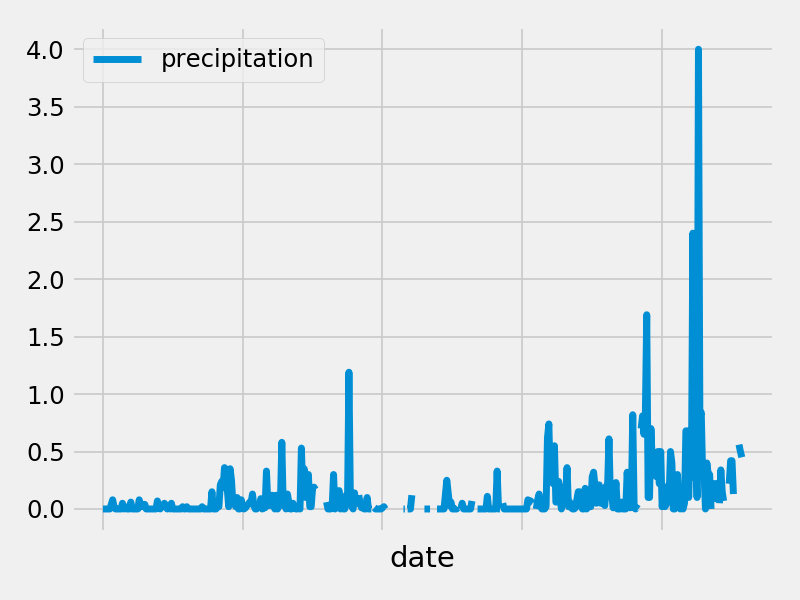

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from today

# Perform a query to retrieve the data and precipitation scores

# Save the query results as a Pandas DataFrame and set the index to the date column

# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data

# Rotate the xticks for the dates


In [151]:
date_string = session.query(func.max(Measurement.date)).one()[0]
most_recent_date = datetime.strptime(date_string,"%Y-%m-%d")
date_string

'2017-08-23'

In [187]:
one_year_earlier = most_recent_date - relativedelta(years=1)

# Starting our data set at one_year_ago doesn't yield very much data,
# because the most recent data in this set is for 2017-08-23.
# So, instead of strictly complying with the original instructions,
# I'm going to get one year of data by going one year back from the most recent
# date for which data is available

q1 = session.query(Measurement.date,
                         func.sum(Measurement.prcp))\
    .filter(Measurement.date > one_year_earlier)\
    .group_by(Measurement.date)\
    .order_by(Measurement.date)

d = dict(q1.all())
df = pd.DataFrame.from_dict(d, orient='index', columns=['precipitation'])
df = df.sort_index()


In [185]:
# This is for generating tick mark indexes.
# I want x tick marks only for the first day of each month
from itertools import compress
dates = [datetime.strptime(d,"%Y-%m-%d") for d in df.index]
test_for_first = [d.day==1 for d in dates]
first_of_each_month = list(compress(enumerate(dates),test_for_first))
x_tick_positions = zip(*first_of_each_month).__next__()

<IPython.core.display.Javascript object>


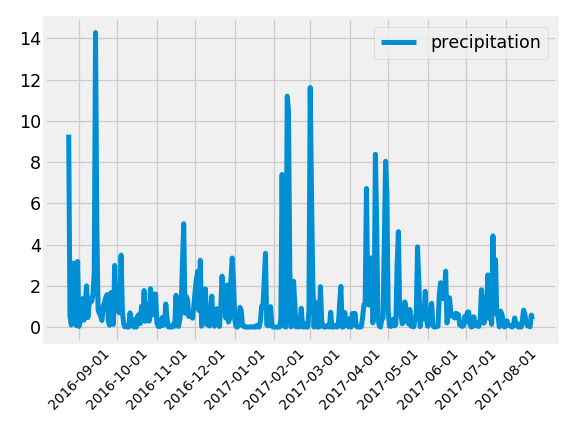

In [212]:
p = df['precipitation']
plt.plot(p)
plt.xticks(x_tick_positions, df.index[test_for_first], rotation=45, size = 11)
plt.legend()
plt.tight_layout()


In [95]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,precipitation
count,26.000000
mean,0.234231
std,0.241349
min,0.000000
25%,0.060000
50%,0.140000
75%,0.407500
max,0.820000


In [101]:
# How many stations are available in this dataset?
session.query(func.count(Station.id)).all()


[(9)]

In [190]:
# What are the most active stations?
# List the stations and the counts in descending order.
q2 = session.query(Measurement.station, func.count(Measurement.id))\
    .group_by(Measurement.station)\
    .order_by(func.count(Measurement.id).desc())
most_active_station = q2.first()[0]
q2.all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [191]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
q3 = session.query(func.min(Measurement.tobs),
                   func.max(Measurement.tobs),
                   func.avg(Measurement.tobs))\
    .filter(Measurement.station == most_active_station)
q3.all()    

[(54.0, 85.0, 71.66378066378067)]

<IPython.core.display.Javascript object>


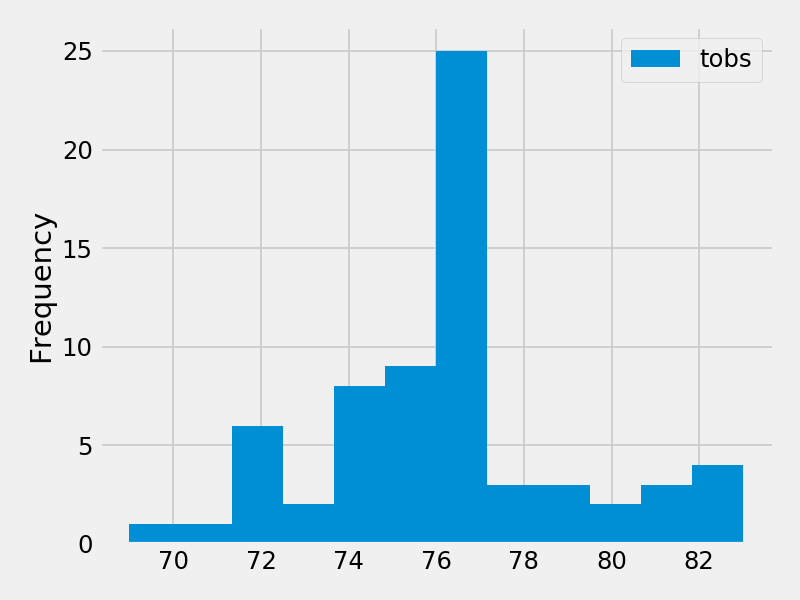

In [15]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


In [207]:
# Theoretically some measurements could lack a temperature.
# Such measurements should be excluded from the station's count. 
q4 = session.query(Measurement.station, func.count(Measurement.tobs))\
    .filter(Measurement.tobs != None)\
    .group_by(Measurement.station)\
    .order_by(func.count(Measurement.tobs).desc())
most_active_station = q4.first()[0]

q5 = session.query(Measurement.tobs)\
    .filter(Measurement.date > one_year_earlier)\
    .filter(Measurement.station == most_active_station)

observations = q5.all()
observations = [o[0] for o in observations]


<IPython.core.display.Javascript object>


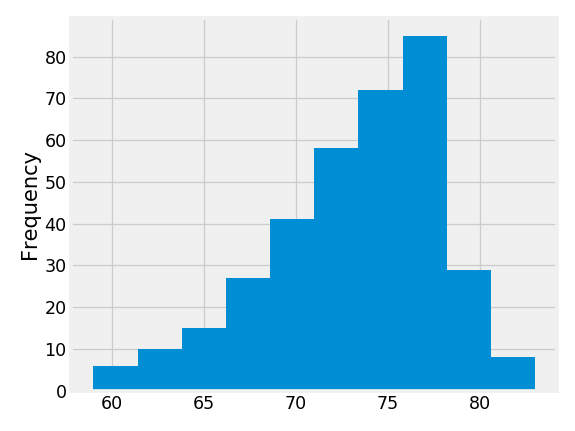

In [215]:
plt.figure()
plt.hist(observations)
plt.ylabel("Frequency")
plt.tight_layout()

In [10]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [15]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
my_trip_start_date = datetime.strptime('2018-08-04',"%Y-%m-%d")
my_trip_end_date = datetime.strptime('2018-08-07',"%Y-%m-%d")
previous_year_start_date = (my_trip_start_date - relativedelta(years=1)).strftime("%Y-%m-%d")
previous_year_end_date = (my_trip_end_date - relativedelta(years=1)).strftime("%Y-%m-%d")
previous_year_temp_range = calc_temps(previous_year_start_date, previous_year_end_date)
previous_year_temp_range

[(77.0, 80.5625, 83.0)]

<IPython.core.display.Javascript object>


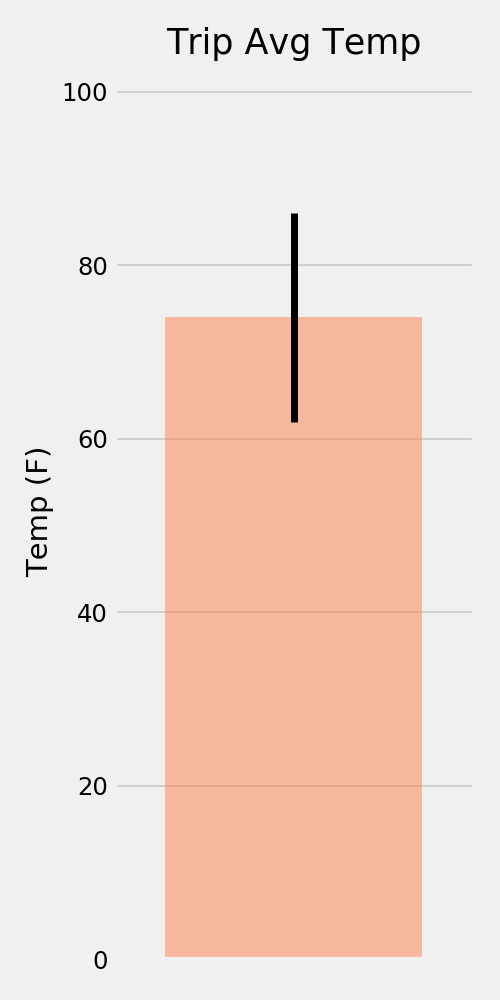

In [18]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [16]:
(tmin, tavg, tmax) = previous_year_temp_range[0]
print(tmin, tavg, tmax)

77.0 80.5625 83.0


<IPython.core.display.Javascript object>


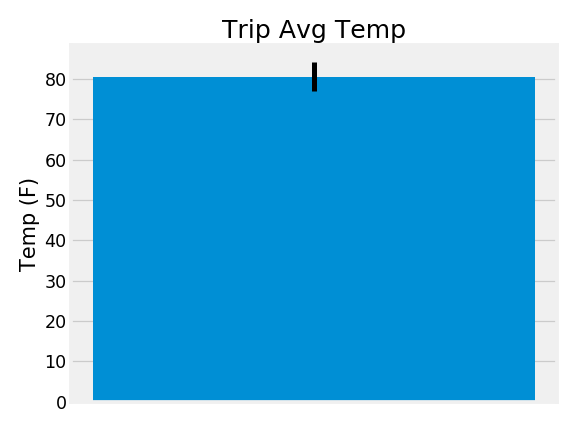

In [19]:
plt.figure()
plt.bar(0, tavg, yerr = [[tavg-tmin, tmax-tavg]])
plt.title("Trip Avg Temp")
plt.ylabel("Temp (F)")
plt.xticks([])
plt.tight_layout()

In [19]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.31), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.25), ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 0.1), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.060000000000000005), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.0), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.0), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0)]


In [28]:
# Only 5 of the 9 stations have data for last year's matching dates of my August 2018 vacation.
session.query(Station.station,
              Station.name,
              Station.latitude,
              Station.longitude,
              Station.elevation,
              func.sum(Measurement.prcp))\
    .filter(Station.station == Measurement.station)\
    .filter(Measurement.date >= previous_year_start_date).filter(Measurement.date <= previous_year_end_date)\
    .group_by(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation)\
    .order_by(func.sum(Measurement.prcp).desc())\
    .all()


[('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  0.06),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  0.05),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  0.04),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.02),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  0.0)]

## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


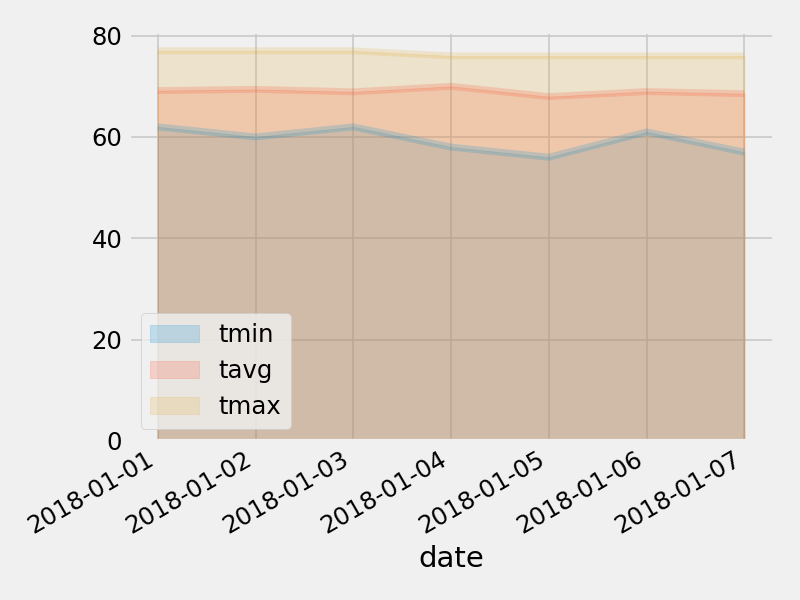

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
